<a href="https://colab.research.google.com/github/pushkar-hue/Foresight/blob/main/lstm_for_household_electric_power_cb225cfe_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/electric-power-consumption-data-set


In [8]:
cd /kaggle/input/electric-power-consumption-data-set

/kaggle/input/electric-power-consumption-data-set


In [9]:
ls

household_power_consumption.txt


In [10]:
path +="/household_power_consumption.txt"

In [11]:
path

'/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt'

Data shape after initial processing: (34589, 7)
Train period: 2006-12-16 17:00:00 to 2007-12-16 16:00:00
Test period: 2007-12-16 17:00:00 to 2010-11-26 21:00:00
Using device: cuda

PyTorch Model Architecture:
BidirectionalLSTMAttention(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attention_weights): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Epoch 1/50 | Train Loss: 0.0423 | Val Loss: 0.0112 | LR: 0.001000
Epoch 2/50 | Train Loss: 0.0166 | Val Loss: 0.0147 | LR: 0.001000
Epoch 3/50 | Train Loss: 0.0154 | Val Loss: 0.0077 | LR: 0.001000
Epoch 4/50 | Train Loss: 0.0089 | Val Loss: 0.0035 | LR: 0.001000
Epoch 5/50 | Train Loss: 0.0058 | Val Loss: 0.0025 | LR: 0.001000
Epoch 6/50 | Train Loss: 0.0045 | Val Loss: 0.0024 | LR: 0.001000
Epoch 7/50 | Train Loss: 0.0046 | Val Loss: 0.0018 | LR: 0.001000
Epoch 8/50 | Train Loss: 0.0037 | 

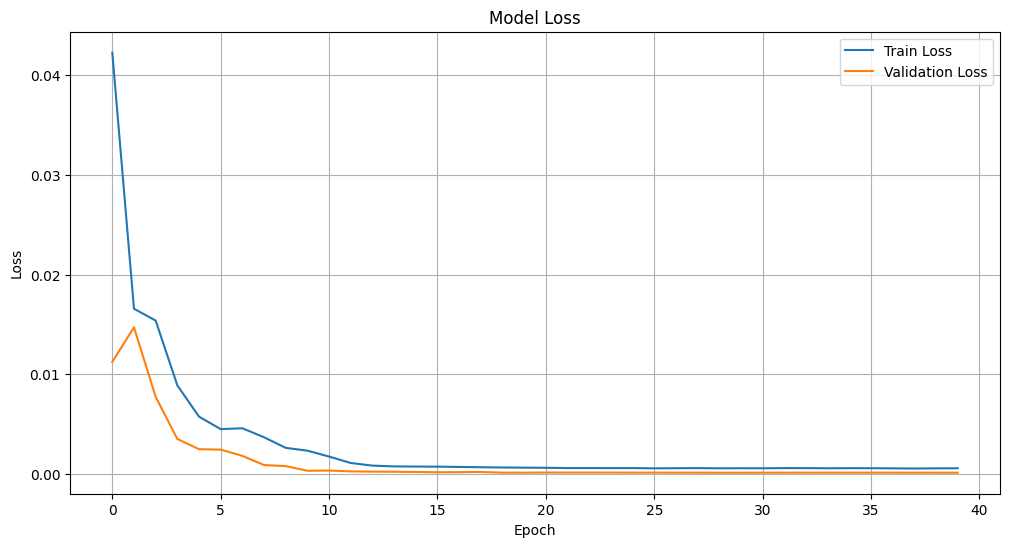


Test Metrics:
RMSE: 0.067
MAE: 0.050
MAPE: 11.92%


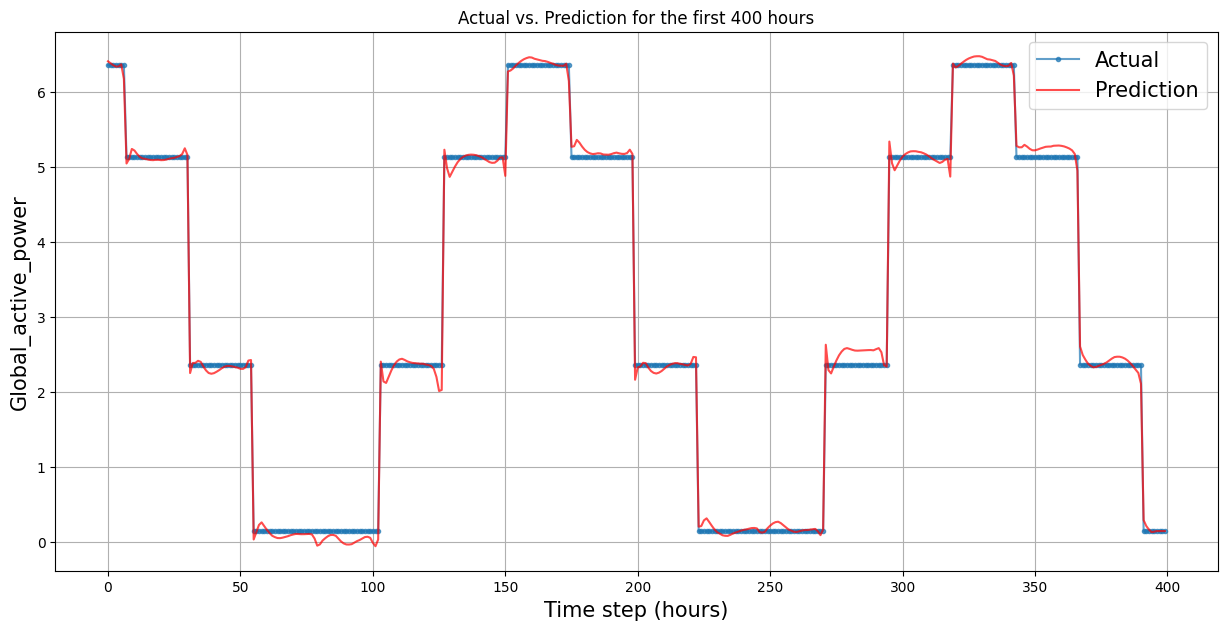

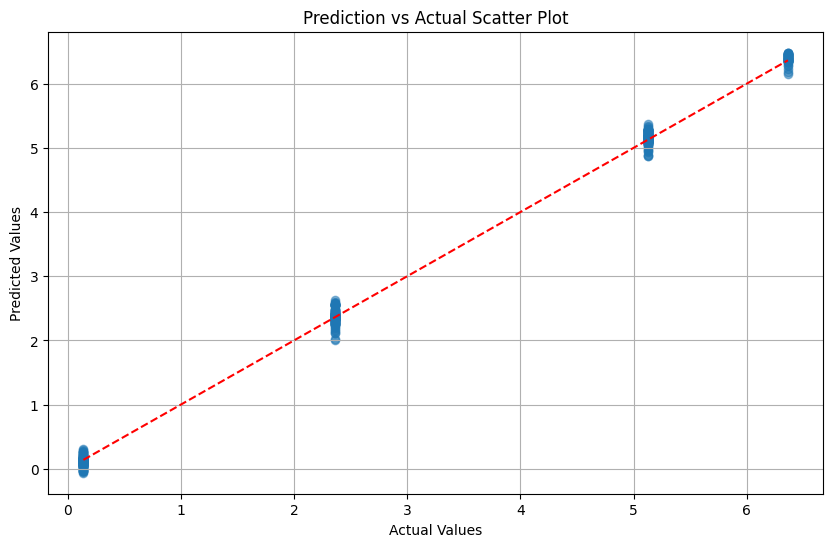


Data leakage prevention measures implemented:
✓ Train/test split performed before feature engineering
✓ Scaler fitted only on training data
✓ Time features created separately for each split
✓ Proper inverse transformation method
✓ Early stopping to prevent overfitting
✓ Gradient clipping for training stability


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# PyTorch Imports
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- 1. DATA LOADING AND INITIAL PROCESSING ---

# Load the dataset - FIXED: Define file path
df = pd.read_csv(path, sep=';', low_memory=False, na_values=['nan', '?'])

# Validate required columns exist
required_cols = ['Date', 'Time', 'Global_active_power']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Date parsing
df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.set_index('dt')
df = df.drop(['Date', 'Time'], axis=1)

# Fill missing values
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

# Resample to hourly frequency
df_resample = df.resample('h').mean()

# Validate we have sufficient data
if len(df_resample) < 365 * 24 + 100:  # At least a year + buffer for test
    raise ValueError("Insufficient data for train/test split")

print("Data shape after initial processing:", df_resample.shape)

# --- 2. TRAIN/TEST SPLIT FIRST (PREVENT DATA LEAKAGE) ---

n_train_hours = 365 * 24
train_df = df_resample.iloc[:n_train_hours].copy()
test_df = df_resample.iloc[n_train_hours:].copy()

print(f"Train period: {train_df.index[0]} to {train_df.index[-1]}")
print(f"Test period: {test_df.index[0]} to {test_df.index[-1]}")

# --- 3. FEATURE ENGINEERING ON SPLIT DATA ---

def add_time_features(data):
    """Add time-based features to the dataset"""
    data_copy = data.copy()
    data_copy['hour'] = data_copy.index.hour
    data_copy['day_of_week'] = data_copy.index.dayofweek
    data_copy['day_of_year'] = data_copy.index.dayofyear
    data_copy['month'] = data_copy.index.month

    # Encode cyclical features
    data_copy['hour_sin'] = np.sin(2 * np.pi * data_copy['hour']/24.0)
    data_copy['hour_cos'] = np.cos(2 * np.pi * data_copy['hour']/24.0)
    data_copy['day_of_week_sin'] = np.sin(2 * np.pi * data_copy['day_of_week']/7.0)
    data_copy['day_of_week_cos'] = np.cos(2 * np.pi * data_copy['day_of_week']/7.0)

    # Drop original time features
    data_copy = data_copy.drop(['hour', 'day_of_week'], axis=1)
    return data_copy

# Apply feature engineering to each split separately
train_df = add_time_features(train_df)
test_df = add_time_features(test_df)

# Ensure target variable is first column
target_col = 'Global_active_power'
cols = [target_col] + [col for col in train_df.columns if col != target_col]
train_df = train_df[cols]
test_df = test_df[cols]

# --- 4. SCALING (FIT ONLY ON TRAINING DATA) ---

train_values = train_df.values
test_values = test_df.values

# Fit scaler ONLY on training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_values)
scaled_test = scaler.transform(test_values)  # Transform only, no fitting

# --- 5. HELPER FUNCTION ---
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# --- 6. CREATE SUPERVISED DATASETS ---

n_steps = 24
n_features = train_df.shape[1]

# Create supervised training set
train_reframed = series_to_supervised(scaled_train, n_steps, 1)
train_reframed.drop(train_reframed.columns[[(n_steps * n_features) + i for i in range(n_features - 1)]],
                    axis=1, inplace=True)

# Create supervised test set
test_reframed = series_to_supervised(scaled_test, n_steps, 1)
test_reframed.drop(test_reframed.columns[[(n_steps * n_features) + i for i in range(n_features - 1)]],
                   axis=1, inplace=True)

# Split training data into train and validation sets
train_values = train_reframed.values
train_size = int(len(train_values) * 0.8)
train, val = train_values[:train_size], train_values[train_size:]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test_reframed.values[:, :-1], test_reframed.values[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
val_X = val_X.reshape((val_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

# Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_X_tensor = torch.from_numpy(train_X).float().to(device)
train_y_tensor = torch.from_numpy(train_y).float().view(-1, 1).to(device)
val_X_tensor = torch.from_numpy(val_X).float().to(device)
val_y_tensor = torch.from_numpy(val_y).float().view(-1, 1).to(device)
test_X_tensor = torch.from_numpy(test_X).float().to(device)
test_y_tensor = torch.from_numpy(test_y).float().view(-1, 1).to(device)

# Create DataLoaders
batch_size = min(70, len(train_X) // 10)  # Adaptive batch size
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(val_X_tensor, val_y_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(test_X_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 7. IMPROVED PYTORCH MODEL ---
class BidirectionalLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, dropout):
        super(BidirectionalLSTMAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.attention_weights = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_scores = self.attention_weights(lstm_out).squeeze(-1)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context_vector = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)
        return out

# Model hyperparameters
INPUT_DIM = n_features
HIDDEN_DIM = 128
N_LAYERS = 2
OUTPUT_DIM = 1
DROPOUT = 0.2

model = BidirectionalLSTMAttention(INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

print("\nPyTorch Model Architecture:")
print(model)

# --- 8. TRAINING LOOP WITH EARLY STOPPING ---
epochs = 50
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience = 10
patience_counter = 0
best_model_state = None  # Store best model state in memory instead of file

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    validation_loss = running_val_loss / len(val_loader)
    val_losses.append(validation_loss)

    # Early stopping check
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        patience_counter = 0
        # Save best model state in memory (Colab-friendly)
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1

    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {validation_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

# --- 9. IMPROVED EVALUATION ---
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- 10. CORRECTED INVERSE TRANSFORMATION ---

# Test the model
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

# CORRECTED: Proper inverse transformation
# Create dummy arrays with same shape as original data for inverse scaling
def inverse_transform_target(scaler, scaled_values, n_features):
    """Properly inverse transform only the target variable"""
    # Create dummy array with zeros for other features
    dummy = np.zeros((len(scaled_values), n_features))
    dummy[:, 0] = scaled_values  # Put target in first column

    # Inverse transform
    inverse_transformed = scaler.inverse_transform(dummy)
    return inverse_transformed[:, 0]  # Return only the target column

# Inverse transform predictions and actual values
inv_predictions = inverse_transform_target(scaler, predictions, n_features)
inv_actuals = inverse_transform_target(scaler, actuals, n_features)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_actuals, inv_predictions))
mae = np.mean(np.abs(inv_actuals - inv_predictions))
mape = np.mean(np.abs((inv_actuals - inv_predictions) / inv_actuals)) * 100

print(f'\nTest Metrics:')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MAPE: {mape:.2f}%')

# --- 11. VISUALIZATION ---
plt.figure(figsize=(15, 7))
n_plot = min(400, len(inv_actuals))
time_steps = range(n_plot)

plt.plot(time_steps, inv_actuals[:n_plot], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, inv_predictions[:n_plot], 'r-', label="Prediction", alpha=0.7)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step (hours)', size=15)
plt.legend(fontsize=15)
plt.title(f'Actual vs. Prediction for the first {n_plot} hours')
plt.grid(True)
plt.show()

# Additional diagnostic plot
plt.figure(figsize=(10, 6))
plt.scatter(inv_actuals[:n_plot], inv_predictions[:n_plot], alpha=0.5)
plt.plot([inv_actuals.min(), inv_actuals.max()], [inv_actuals.min(), inv_actuals.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual Scatter Plot')
plt.grid(True)
plt.show()

print("\nData leakage prevention measures implemented:")
print("✓ Train/test split performed before feature engineering")
print("✓ Scaler fitted only on training data")
print("✓ Time features created separately for each split")
print("✓ Proper inverse transformation method")
print("✓ Early stopping to prevent overfitting")
print("✓ Gradient clipping for training stability")